# Deep learning from scratch: homework 3

### General instructions

Complete the exercises listed below in this Jupyter notebook - leaving all of your code in Python cells in the notebook itself.  Feel free to add any necessary cells.  

Included with the notebook are 

- a custom utilities file called `custom_plotter.py` that provides various plotting functionalities (for unit tests to help you debug) as well as some other processing code.


- datasets for exercises: `noisy_sin_sample.csv` and `2_eggs.csv`.

be sure you have these files located in the same directory where you put this notebook to work!

### When submitting this homework:
    
**Make sure all output is present in your notebook prior to submission**

#### <span style="color:#a50e3e;">Exercise 4. </span>  Read the notes below

Yes, thats it, **there is nothing to turn in for this exercise** (yes, you will get these points for free!).  Just read the notes below!  You will find useful concepts - and blocks of code - for further exercises there.

In [1]:
# import autograd functionality
import autograd.numpy as np
from autograd.misc.flatten import flatten_func
from autograd import grad as compute_grad   

# import custom utilities and plotter
import custom_plotter as plotter

# import various other libraries
import copy
import matplotlib.pyplot as plt

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

# %matplotlib notebook
%load_ext autoreload
%autoreload 2

Feel free to use the following ``gradient_descent`` function below for this exercise.

In [2]:
# gradient descent function
def gradient_descent(g,w,alpha,max_its,beta,version):    
    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w)
    grad = compute_grad(g_flat)

    # record history
    w_hist = []
    w_hist.append(unflatten(w))

    # start gradient descent loop
    z = np.zeros((np.shape(w)))      # momentum term
    
    # over the line
    for k in range(max_its):   
        # plug in value into func and derivative
        grad_eval = grad(w)
        grad_eval.shape = np.shape(w)

        ### normalized or unnormalized descent step? ###
        if version == 'normalized':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm
            
        # take descent step with momentum
        z = beta*z + grad_eval
        w = w - alpha*z

        # record weight update
        w_hist.append(unflatten(w))

    return w_hist

# 3.  (Optimization tricks part 2, continued) Nonlinear features, normalization, and gradient descent performance

As we have seen, whenever we want to perform some sort of nonlinear regression or classification, we transform the input of a dataset using a linear combination of $U$ *nonlinear* feature transformations $f_1\,,f_2\,..,f_U$, having a prediction function that (for single dimensional input) looks like 

\begin{equation}
\text{predict}\left({x},\omega\right) = w_0 + w_1\,f_1\left({x}\right) + \cdots + w_U\,f_U\left({x}\right)
\end{equation}

*In theory* the more feature transformations - often called just *features* for short - we use, the more nonlinear our prediction becomes.  Indeed if we use too many we risk overfitting any dataset.  However *in practice* when optimizing (whether with nonlinear regression or classification) via *gradient descent* with a fixed number of maximum iterations we can often find that it gets harder to fit more nonlinear models to data.  In fact in some instances we can find that as we add nonlinear features our final fit becomes *less* nonlinear because our cost function has become harder for gradient descent to minimize properly. 

This confusing empirical fact is due to precisely the sort of input normalization issue described in the previous exercises.  That is, often nonlinear feature transformations *create* highly imbalanced input distributions, which in turn create the sort of long narrow valleys we try to avoid when using (either normalized or unnormalized) gradient descent as an optimizer. 

## 3.1  Fixed kernel feature transformations

To apply fixed features we take a set of *ordered basis functions* s $f_1,f_2,...,f_U$ (with no internal parameters) and transform the input.  In the next ``Python`` cell we give a compact feature transformation function called ``compute_features`` that does just this for *polynomial features*: we plug in our entire set of input and the first $U$ monomial features of it are returned.  In other words this returns a sequence of $P\times 1$ *transformed* inputs $\mathbf{f}_u$

\begin{equation}
\mathbf{f}_u = \begin{bmatrix}
f_u\left(x_1\right) \\
f_u\left(x_2\right) \\
\vdots \\
f_u\left(x_P\right) \\
\end{bmatrix}
\end{equation}

which contains each of our input points raised to the $u^{th}$ power.

In [3]:
# compact functionality for creating polynomial feature transformations - degree polynomials between 1 and U
def compute_features(x,U):
    return np.asarray([x**deg for deg in range(1,U+1)])[:,:,0].T

Remember: when employing such a fixed feature transformation $\mathbf{f}_u$ becomes our $u^{th}$ input dimension, and its distribution touches the weight $w_u$ (you can see this by examining the form of our ``predict`` function in equation (1)).  Thus having previously seen the effect of unnormalized versus normalized input feature distributions first hand in the case of *linear* regression / classification, we can expect something quite similar to arise in the nonlinear case based on the distribution of our features $\mathbf{f}_u$ (notice we never apply any 'normalization' to the bias since only one value touches it - the number $1$).  In other words, if the distributions of our transformed input dimensions are not by design similar, we can expect that normalizing them will substantially improve the performance of gradient descent since this will ameliorate (at least to some extent) the problem of long narrow valleys.

> If the distributions of our transformed input dimensions are not by design similar, we can expect that normalizing them will substantially improve the performance of gradient descent since this will ameliorate (at least to some extent) the problem of long narrow valleys.

#### <span style="color:#a50e3e;">Example 1. </span>  The distribution of polynomial features for a toy dataset

Lets begin by examining a the distribution of polynomial features for the toy sinusoidal dataset loaded in and shown below.

/Users/ikhlas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


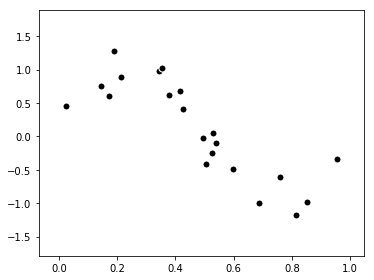

In [4]:
# load data
csvname = 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:,:-1]
y = data[:,-1:]

# plot everything
plotter_demo = plotter.Visualizer()
plotter_demo.plot_regression_data(x,y)

To get a sense of the distribution of transformed features in our present case we can compute and plot each of the first $U = 20$ of them for our toy dataset.  We can examine then the distribution of each monomial feature using the ``feature_distributions`` plotting function introduced in the previous exercise.  A copy of this has been also in our ``custom_utilities`` backend file, and we can call it as shown below (no need to repeat the code block defining this function).

In [5]:
# make degree 20 polynomial features
U = 20
f = compute_features(x,U)

/Users/ikhlas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


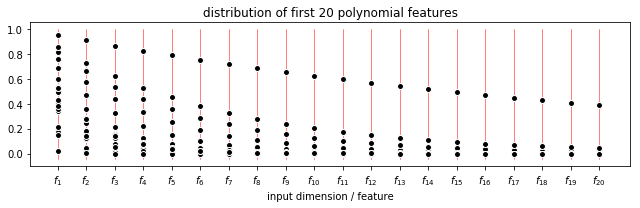

In [6]:
# show a plot of the distribution of each feature
title = 'distribution of first 20 polynomial features'
labels = [r'$f_{' + str(n+1) + '}$' for n in range(U)]
plotter_demo.feature_distributions(f,title,labels=labels)

These feature distributions are really collapsing rapidly and are - all together - not very similar across the feature space.  Why is this happening?  Because the input points in $\mathbf{x}$ here all lie in the range $[0,1]$, and raising any value in that range to a power makes it exponentially *smaller*.

Therefore we can expect gradient descent to be slow to converge if these unnormalized input features are used (an example below using our toy dataset will confirm this suspicion).  Indeed if left unnormalized this sort of feature distribution imbalance can lead to substantially increased difficulty in properly tuning nonlinear models (using gradient descent) as we increase the number of feature transformations $U$.  And we have done it to ourselves - in applying nonlinear feature transformations (here polynomials, but this is more commonly true as well) we *create* this problem.

> If left unnormalized fixed feature distribution imbalance can lead to substantially increased difficulty in properly tuning nonlinear models (using gradient descent) as we increase the number of fixed feature transformations $U$. 

At the extremes this can even lead to confusing scenarios where adding more nonlinear features does not improve the nonlinearity of a tuned model as one expects, because fine tuning via gradient descent has been made increasingly difficult with each added nonlinear feature dimension.  For example with polynomials - as indicated in our example here - the problem typically gets *worse* as we add more monomial terms since monomials exponentially *shrink* values in the interval $(-1,1)$ and exponentially *grow* essentially all other values (i.e., those with absolute value greater than 1).

---

Now when we take polynomial features we have some values that will grow exponentially *larger*.  So not even our standard normalization of the input can save us from ourselves in this case.  We need to normalize the nonlinear features themselves.  We normalize each by subtracting off their mean and dividing by their standard deviation

\begin{equation}
f_u \left(x_p \right) \longleftarrow \frac{f_u \left(x_p \right) - \mu_{f_u}}{\sigma_{f_u}}
\end{equation}

where

\begin{array}
\
\mu_{f_u} = \frac{1}{P}\sum_{p=1}^{P}f_u\left(x_p \right) \\
\sigma_{f_u} = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(f_u\left(x_p \right) - \mu_{f_u} \right)^2}.
\end{array}

Normalizing both the original input and the nonlinear features we would likewise replace each feature with

\begin{equation}
f_u \left(x_p \right) \longleftarrow \frac{f_u \left(\frac{x_p - \mu_{x}}{\sigma_{x}} \right) - \mu_{f_u}}{\sigma_{f_u}}.
\end{equation}

With this input/feature normalization we can write our normalized ``predict_normalized`` function using this notation as

\begin{equation}
\text{predict_normalized}\left(x,\omega\right) = w_0 + w_1\left(\frac{f_1\left(\frac{x - \mu_x}{\sigma_x} \right) - \mu_{f_1}}{\sigma_{f_1}}\right) + w_2\left(\frac{f_2\left(\frac{x - \mu_x}{\sigma_x} \right) - \mu_{f_2}}{\sigma_{f_2}}\right) + \cdots + w_U\left(\frac{f_U\left(\frac{x - \mu_x}{\sigma_x} \right) - \mu_{f_U}}{\sigma_{f_U}}\right).
\end{equation} 

Now every weight in our model (with the exception of the bias of course) is attached to a normalized distribution of data.  Note in the instance our input $\mathbf{x}$ is in general $N$ dimensional we normalize along each coordinate, giving the general normalized update

\begin{equation}
\text{predict_normalized}\left(\mathbf{x},\omega\right) = w_0 + w_1\left(\frac{f_1\left(\frac{x_1 - \mu_{x_1}}{\sigma_{x_1}},\frac{x_2 - \mu_{x_2}}{\sigma_{x_2}},...,\frac{x_N - \mu_{x_N}}{\sigma_{x_N}} \right) - \mu_{f_1}}{\sigma_{f_1}}\right) + \cdots + w_U\left(\frac{f_U\left(\frac{x_1 - \mu_{x_1}}{\sigma_{x_1}},\frac{x_2 - \mu_{x_2}}{\sigma_{x_2}},...,\frac{x_N - \mu_{x_N}}{\sigma_{x_N}}  \right) - \mu_{f_U}}{\sigma_{f_U}}\right).
\end{equation} 

where $\mu_{x_n}$ and $\sigma_{x_n}$ are the mean and standard deviation of the data along the $n^{th}$ dimension of the input.

#### <span style="color:#a50e3e;">Example 2. </span>  The distribution of normalized polynomial features for a toy dataset

Here we normalize the input data and then corresponding polynomial featurese for the noisy sinusoidal dataset in Example 1.  Following we visualize the distribution of the first $U = 20$ normalized polynoimal features, mirroring the plot shown in the previous example.

In [7]:
# our normalization function
def normalize(data,data_mean,data_std):
    normalized_data = (data - data_mean)/data_std
    return normalized_data

In [8]:
# compute the mean and standard deviation of our input
x_means = np.mean(x,axis = 0)
x_stds = np.std(x,axis = 0)

# normalize data using the function above
x_normed = normalize(x,x_means,x_stds)

In [9]:
# make degree 5 polynomial features
U = 20
f = compute_features(x_normed,U)

# normalize polynomial features
f_means = np.mean(f,axis = 0)
f_stds = np.std(f,axis = 0)

# normalize features using the function above
f_normed = normalize(f,f_means,f_stds)

/Users/ikhlas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


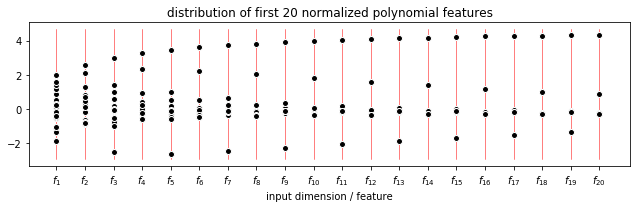

In [10]:
# show a plot of the distribution of each feature
title = 'distribution of first 20 normalized polynomial features'
labels = [r'$f_{' + str(n+1) + '}$' for n in range(U)]
plotter_demo.feature_distributions(f_normed,title,labels=labels)

Clearly normalizing does not completely fix the problem of uneven feature distributions here, as the *exponential* shrinking / enlarging property of polynomial terms is too powerful to be completely counteracted by mere normalization (this is indeed one of their major practical flaws).  However even so, normalization aids the convergence of gradient descent considerably - as we will see in the next example. 

#### <span style="color:#a50e3e;">Example 3. </span>  Unnormalized versus normalized polynomial features and gradient descent convergence

In this example we use a degree $U = 5$ polynomial model to fit our toy dataset and compare how rapidly the model can be properly tuned when we use the raw nonlinear features themselves versus when we normalize both the input data and features.  Starting with the unnormalized case, in the next cell we have our ``predict`` and ``least_squares`` implementations.  

In [11]:
# number of polynomial features to use
U = 5

# our predict function 
def predict(x,w):        
    # compute our current set of features
    f = compute_features(x,U)  

    # compute linear model
    vals = w[0] + np.dot(f,w[1:])
    return vals

# least squares
least_squares = lambda w: np.sum((predict(x,w) - y)**2)

Note how our implementation is a direct translation of the ``predict`` formula in equation (1), which we have done for ease of exposition.  However the way this is implemented polynomial features will be computed for the input of our toy dataset every time ``predict`` is called (i.e., at every step of gradient descent).  Since the polynomials have no internal weights that need updating from one descent step to another this is computationally wasteful, but on such a small dataset like the one we deal with here the overhead is not significant.

In the next cell we run gradient descent to fit our polynomial model using unnormalized gradient descent with a steplength parameter $\alpha$ of the form $10^{-\gamma}$ where $\gamma$ is the smallest positive integer that produces convergence with an initial point $\mathbf{w}^0 = \begin{bmatrix} 0 \\ \vdots \\ 0 \end{bmatrix}$ at the origin (all zeros).

In [12]:
# parameters of gradient descent
alpha = 10**(-2); max_its = 1000; beta = 0; w_init = np.zeros((U+1,1));
w_init = 0.1*np.random.randn(U+1,1)

# run gradient descent, create cost history (for cost function plot comparison) associated with output weight history
weight_history_1 = gradient_descent(least_squares,w_init,alpha,max_its,beta,version = 'unnormalized')
cost_history_1 = [least_squares(v) for v in weight_history_1]

To evaluate new testing input using our trained model we simply plug them into our ``predict`` function (we will do this after running the normalized version of this experiment). 

Now we repeat the same experiment only we normalize both our input and polynomial features.  Here will see that far fewer gradient descent steps are needed to produce an even better fit.  In what follows we will implement the input and feature normalized prediction function precisely as stated in equation (5) above.  First, however, we need to compute the input and feature statistics (their mean and standard deviations). 

In [13]:
# compute the mean and standard deviation of the input
x_means = np.mean(x,axis = 0)
x_stds = np.std(x,axis = 0)

# normalize input using the statistics above
x_normed = normalize(x,x_means,x_stds)

# compute features of our normalized input
f = compute_features(x_normed,U)  

# compute the mean and standard deviation of our features
f_means = np.mean(f,axis = 0)
f_stds = np.std(f,axis = 0)

With these statistics in hand, we can then implement our input/feature normalized ``predict`` function.  Again this implementation - while a direct translation of the ``predict_normalized`` formula in equation (5) - is inefficient: since polynomials have no internal parameters we can pre-compute the normalized features on the training input beforehand (instead of re-computing these whenever ``predict_normalized`` is called), but for our small toy dataset this overhead will not be prohibitive.

In [14]:
# our predict function 
def predict_normalized(x,w):   
    # normalize input
    x_normed = normalize(x,x_means,x_stds)
    
    # compute features of normalized input
    f = compute_features(x_normed,U)  

    # normalize the training data features 
    f_normed = normalize(f,f_means,f_stds)

    # compute linear model
    vals = w[0] + np.dot(f_normed,w[1:])
    return vals

# least squares
least_squares = lambda w: np.sum((predict_normalized(x,w) - y)**2)

Now we run gradient descent using the same parameters as previously, though note a smaller steplength parameter $\alpha$ (of our generic form $10^{-\gamma}$ had to be used.

In [15]:
# parameters of gradient descent
alpha = 10**(-3); max_its = 1000; beta = 0; w_init = w_init;

# run gradient descent, create cost history (for cost function plot comparison) associated with output weight history
weight_history_2 = gradient_descent(least_squares,w_init,alpha,max_its,beta,version = 'unnormalized')
cost_history_2 = [least_squares(v) for v in weight_history_2]

With both experiments now complete we can compare the cost function history of each gradient descent run.  We do this in the cell below.  In the normalized case we converge much more rapidly than the unnormalized case.

/Users/ikhlas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


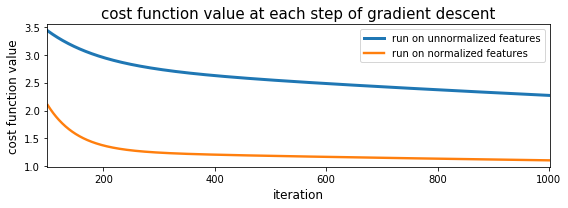

In [16]:
# plot the cost function history for our current run of gradient descent
histories = [cost_history_1, cost_history_2]
labels = ['run on unnormalized features','run on normalized features']
plotter_demo.compare_regression_histories(histories,start=100,labels=labels)

Now we can evaluate either version of the degree 5 model with new testing data.  Doing this for a fine sampling of input points along the interval where our toy data is defined we can visualize our nonlinear fit to the data.  Clearly (from the cost history plot above) the normalized version will produce the better fit - and indeed it does.

/Users/ikhlas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


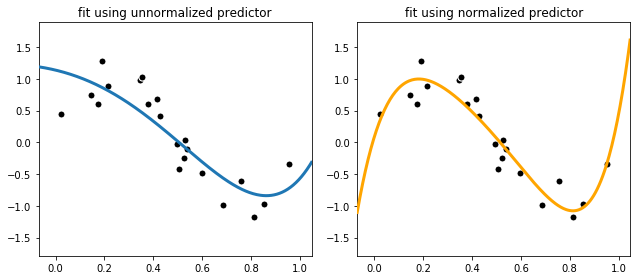

In [17]:
# compare final fits using unnormalized and normalized predictors
plotter_demo.compare_regression_fits(x,y,predict,predict_normalized,weight_history_1[-1],weight_history_2[-1],title1 = 'fit using unnormalized predictor',title2 = 'fit using normalized predictor')

## 3.2  Single hidden layer perceptron / feedforward network feature transformations

Thus far we have seen how normalizing each input dimension of a dataset, as well each dimension of a fixed kernel feature transformation (e.g., each polynomial degree of a single input dataset), significantly aids gradient descent in terms of convergence to optimal parameter values.  In other words, thus far we have seen how normalizing the distribution of every single feature dimension that touches a weight makes gradient descent run faster (because it alleviates the long narrow valley problem).  

>  Thus far we have seen how normalizing every distribution that touches a weight makes gradient descent run faster (because it alleviates the long narrow valley problem).  This same intuition carries over to multilayer perceptrons - only now we also have *internal* weights that touch distributions of *activation outputs*.  

This intuition carries over completely from fixed features to parameterized networks - why should it not?  The only wrinkle is that since network features are recursive and parameterized that we will have to normalize not just the input data and final network features, but every dimension of a network that touches a single weight.  Because of the way a network is put together this consists of normalizing the output of each and every activation unit, since each of these touches an individual weight.  We will quickly review why this is the case below.

When employing network features, our ``predict`` function takes the form

\begin{equation}
\text{predict}\left(\mathbf{x},\omega\right) = w_0 + w_1\,f_1\left(\mathbf{x},\omega_1\right) + \cdots + w_U\,f_U\left(\mathbf{x},\omega_U\right)
\end{equation}

where each nonlinear feature $f_u$ is a recursively defined parameterized function (here $\omega_u$ is the set of $f_u$'s internal weights).  In the case of a single hidden layer these features take the form

\begin{equation}
f_u\left(x_1,x_2,\ldots,x_N, \omega_u\right)=a\left(w_{0,u}+\underset{n=1}{\overset{N}{\sum}}{w_{n,u}\,x_n}\right)
\end{equation}

where $a\left(\cdot\right)$ is called an *activation function* and is typically chosen from a list of elementary mathematical functions like *tanh*, the *rectified linear unit*, the *maxout* function, etc.,

#### <span style="color:#a50e3e;">Example 4. </span>  Unnormalized single layer feature distributions

Using a *tanh* activation function and $N = 1$, the single layer network feature above can be written as

\begin{equation}
f_u\left(x,\omega_u\right) = \text{tanh}\left(w_{0,u} + w_{1,u}x\right).
\end{equation}

As we did in the previous case with polynomials (in example 1 above) here we use the sinusoidal dataset and plot $U$ of these units $f_1,f_2,...,f_U$, randomly setting each's internal weights.  In the next ``Python`` cell we have a compact feature transformation function called ``compute_features`` that does just this: we plug in our entire set of input into these units and the $U$ activation outputs are returned as the $P\times 1$ *transformed* input vector $\mathbf{f}_u$

\begin{equation}
\mathbf{f}_u = \begin{bmatrix}
f_u\left(x_1,\omega_{f_u}\right) \\
f_u\left(x_2,\omega_{f_u}\right) \\
\vdots \\
f_u\left(x_P,\omega_{f_u}\right). \\
\end{bmatrix}
\end{equation}

In [18]:
def activation(t):
    # tanh activation
    f = np.tanh(t)
    return f

# functionality for creating single hidden layer features
def compute_features(x,w):
    # append one to each datapoint
    o = np.ones((np.shape(x)))
    xt = np.concatenate((o,x),axis = 1)
    
    # take inner product
    inp = np.dot(xt,w)
    
    # now take nonlinear activation
    a = activation(inp)
    return a

Now we can examine a distribution of $U = 20$ units (where each unit has randomized weights).  You can refresh this cell to see different results.

Predictably, we can see that these distributions will be problematic (with regards to the speed of gradient descent) because they are so dissimilar. 

/Users/ikhlas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


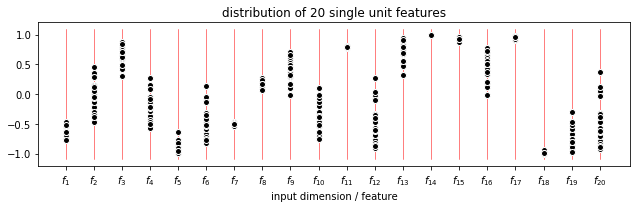

In [19]:
# make degree 5 polynomial features
U = 20
w = np.random.randn(2,U)
f = compute_features(x,w)

# show a plot of the distribution of each feature
title = 'distribution of 20 single unit features'
labels = [r'$f_{' + str(n+1) + '}$' for n in range(U)]
plotter_demo.feature_distributions(f,title,labels=labels)

---

Studying the formula for the single hidden layer unit and the ``predict`` functions above, we can see that the weight $w_u$ acts on the output of the activation function $a\left(\cdot\right)$ over the entire set of inputs.  Therefore normalizing each of these feature / activation output distributions will aid in the gradient descent optimization (we never need to normalize a quantity with respect to either the outer bias $w_0$ or any internal bias weight since only one value ever touches these weights - the number $1$).  This is the complete analog of normalizing polynomial features.

Swapping out a normalized version of the single hidden layer feature / activation output in our ``predict`` function we would make the substitution 

\begin{equation}
f_u\left(x_1,x_2,\ldots,x_N, \omega_u\right)  \longleftarrow \frac{f_u\left(\frac{x_1 - \mu_{x_1}}{\sigma_{x_1}},\frac{x_2 - \mu_{x_2}}{\sigma_{x_2}},...,\frac{x_N - \mu_{x_N}}{\sigma_{x_N}},\omega_u\right) - \mu_{f_u}}{\sigma_{f_u}}
\end{equation}

where $\mu_{x_n}$ / $\sigma_{x_n}$ and $\mu_{f_u}$ / $\sigma_{f_u}$ are the mean and standard deviation of the $n^{th}$ dimension of the input and $u^{th}$ feature / activation output.  

However note importantly: *unlike* the case with fixed kernel functions, here our nonlinearities contain internal parameters.  Thus even if we normalize the activation outputs one time their distribution will change *every time the internal weights in $\omega_u$ do*, i.e., at every gradient descent step!  Another way to think about it: technically our feature statistics are function's of their unit's internal parameters too!  i.e., $\mu_{f_u} \longleftarrow \mu_{f_u}\left(\omega_u\right)$ and $\sigma{f_u} \longleftarrow \sigma{f_u}\left(\omega_u\right)$, thus they need to be re-computed with each change in $\omega_u$.  Because of this,it is very is convenient to simply add a normalization step directly into the feature computation module of a network architecture.

> Activation output distributions must be normalized every time the internal weights of the network change (i.e., at each gradient descent step).  Therefore it is convenient to add a normalization step directly into the feature computation module of a network architecture.

#### <span style="color:#a50e3e;">Example 5. </span>  Unnormalized single layer feature distributions

Here we normalize each feature / activation output distribution shown in the previous example.  Using the same random weights, this plot consists of $U = 20$ single layer tanh units.  In the ``Python`` cells below we i) normalize the input ii) define a new ``compuate_normalized_features`` function that adds an activation output normalization step to the previous feature computation module and iii) plot the normalized feature distributions.

In [20]:
# compute the mean and standard deviation of our input, then normalize the input
x_means = np.mean(x,axis = 0)
x_stds = np.std(x,axis = 0)

# normalize the input data
x_normed = normalize(x,x_means,x_stds)

In [21]:
# functionality for creating single hidden layer features
def compute_features_normalized(x,w):    
    # take linear combination of input
    inp = w[0] + np.dot(x,w[1:])
    
    # now take nonlinear activation
    a = activation(inp)

    # normalize activation output - first compute the mean 
    # and standard deviation of our input
    a_means = np.mean(a,axis = 0)
    a_stds = np.std(a,axis = 0)

    # now normalize
    a_normed = normalize(a,a_means,a_stds)
     
    return a_normed

/Users/ikhlas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


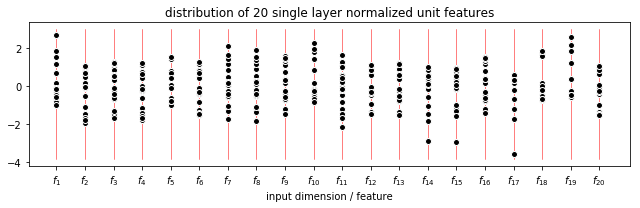

In [22]:
# compute features / units on normalized input
f_normed = compute_features_normalized(x_normed,w)

# show a plot of the distribution of each feature
title = 'distribution of 20 single layer normalized unit features'
labels = [r'$f_{' + str(n+1) + '}$' for n in range(U)]
plotter_demo.feature_distributions(f_normed,title,labels=labels)

These distributions look much better than the unnormalized versions from the previous example - in that they are now much more similar to each other.  

---

Deeper network features are defined by recursing on the simple theme of i) taking a linear combination of the activation output and ii) applying the same activation to this linear combination ([see our notes on multilayer perceptrons for further details](https://jermwatt.github.io/mlrefined/blog_posts/Nonlinear_Supervised_Learning/Part_4_multi_layer_perceptrons.html)). 
).  For example, following this recipe a three layer network feature can be written generically as  

\begin{equation}
f_u^{\left(3\right)}\left(x_1,x_2,\ldots,x_N,\omega_u\right)=a^{(3)}_{\,}\left(w^{\left(3\right)}_{0,u}+\underset{i=1}{\overset{U_2}{\sum}}{w^{\left(3\right)}_{i,u}}\,a^{(2)}_{\,}\left(w^{\left(2\right)}_{0,i}+\underset{k=1}{\overset{U_1}{\sum}}{w^{\left(2\right)}_{k,u}}\,a^{(1)}_{\,}\left(w^{\left(1\right)}_{0,k}+\underset{n=1}{\overset{N}{\sum}}w^{\left(1\right)}_{n,k}\,x_n\right)\right)\right)
\end{equation}

In analogy to what we have seen so far - what quantities should be normalized here to avoid potential long narrow valleys in particular dimensions?  Answer: any distribution touching a weight.  Here this includes 

- the third and final activation output distribution $f_u^{(3)} = a_{\,}^{(3)}$ over all $P$ inputs, since this distribution touches the weight $w_u$


- the second layer activation output distribution $a_{\,}^{(2)}$ for each fixed value of $i$, since each such distribution touches the third layer weight $w^{\left(3\right)}_{i,u}$


- the first layer activation output distribution $a_{\,}^{(1)}$ for each fixed value of $k$, since each such distribution touches the second layer weight $w^{\left(2\right)}_{k,u}$


- the input distribution of the data $x_n$ along the $n^{th}$ dimension for each fixed value of $n$, since each such distribution touches the first layer weight $w^{\left(1\right)}_{n,k}$

This same pattern idea for deeper networks as well - if we want our cost function to suffer less from long narrow valleys when using a set of deep network features we want to make sure each and every weight-touching distribution is normalized.  This set of distributions is comprise of each dimension of the input and every activation output. 

> If we want our cost function to suffer less from long narrow valleys when using a set of deep network features we want to make sure each and every weight-touching distribution is normalized.  This set of distributions is comprise of each dimension of the input and every activation output.

**Note:** Given how helpful we have seen the concept of weight-touching distribution normalization in aiding the convergence of gradient descent for linear regression / classification, as well as with fixed kernel features, it seems quite intuitive that the same concept should be equally beneficial for the case of multilayer perceptrons.   While versions of this idea have surely been used for years by practitioners as a 'hack' for speeding up the training of networks, this notion (in the context of multilayer perceptrons) was only recently published formally in a journal (and it received enormous fan-fare, since the concept is so simple yet so very helpful) where it was given the name [Batch Normalization](https://arxiv.org/abs/1502.03167).

#### <span style="color:#a50e3e;">Example 6. </span>  Comparing unnormalized and normalized deep network activation output distributions

In this example we study every weight-touching distribution of a standard unnormalized and normalized 3 layer network - like the one shown in the equation above - using our sinusoidal dataset first introduced in example 1.  This network will have 7 units in the first layer, 10 in the second layer, and 5 in the third layer (these numbers were chosen at random) and we will use the tanh activation function.   To design / compute this network we will use the ``Python`` based architecture design / computation tools described in [Section 1.4 of our notes on the multilayer perceptron](https://jermwatt.github.io/mlrefined/blog_posts/Nonlinear_Supervised_Learning/Part_4_multi_layer_perceptrons.html).  

In the next cells we define our network architecture, and use the function ``initialize_network_weights`` discussed in the notes to create an a random set of weights for our network.

In [23]:
# A 3 layer network architecture
N = np.shape(x)[1]
M = np.shape(y)[1]
U_1 = 7                # number of units in layer 1
U_2 = 10               # number of units in layer 2
U_3 = 5                # number of units in layer 3

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,M]

In [24]:
# create initial weights for arbitrary feedforward network
def initialize_network_weights(layer_sizes,scale):
    # container for entire weight tensor
    weights = []
    
    # loop over desired layer sizes and create appropriately sized initial 
    # weight matrix for each layer
    for k in range(len(layer_sizes)-1):
        # get layer sizes for current weight matrix
        U_k = layer_sizes[k]
        U_k_plus_1 = layer_sizes[k+1]

        # make weight matrix
        weight = scale*np.random.randn(U_k + 1,U_k_plus_1)
        weights.append(weight)

    # re-express weights so that w_init[0] = omega_inner contains all 
    # internal weight matrices, and w_init[1] = w contains weights of 
    # final linear combination in predict function
    w_init = [weights[:-1],weights[-1]]
    
    return w_init

In [25]:
# generate initial weights for our network
w_init = initialize_network_weights(layer_sizes,scale = 0.1)

Next we have our ``compute_features`` function, which contains our standard unnormalized network architecture. 

In [26]:
# fully evaluate our network features using the tensor of weights in omega_inner
def compute_features(x, omega_inner):
    # pad data with ones to deal with bias
    o = np.ones((np.shape(x)[0],1))
    a_padded = np.concatenate((o,x),axis = 1)
    
    # loop through weights and update each layer of the network
    for W in omega_inner:
        # output of layer activation
        a = activation(np.dot(a_padded,W))
                
        #  pad with ones (to compactly take care of bias) for next layer computation
        o = np.ones((np.shape(a)[0],1))
        a_padded = np.concatenate((o,a),axis = 1)
        
    return a_padded

A version of this function has been placed in the utilities backend file, where we collect the activation output distribution at each iteration of the loop.

With our initial weights defined we can then plot our weight-touching distributions, which we do in the next ``Python`` cell.  In the top panel the distribution of the input data is shown, below this in the second panel is the distribution of each unit in the first layer of the network - the distribution of the $k^{th}$ unit here is denoted $a_{k}^{(1)}$.  In the two panels that follow are the corresponding activation distributions for the second and third layers of the network - here the $i^{th}$ distribution of the second layer is denoted $a_{i}^{(2)}$, and the $u^{th}$ third layer unit distribution $a_{u}^{(3)}$.

/Users/ikhlas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


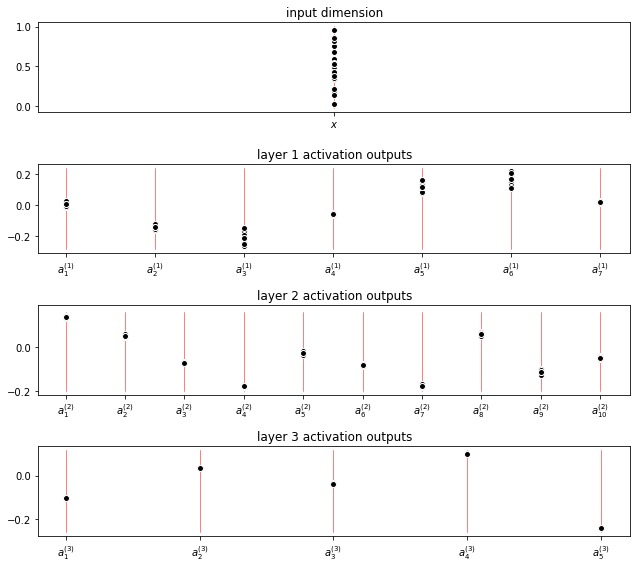

In [27]:
# plot each weight-touching distribution
plotter_demo.activation_distributions(x,w_init)

These clearly look uneven.  By normalizing the input and adding in a normalization step in our computation of the features we can ameliorate this issue.  We do this in the next two ``Python`` cells.  We call our normalized network update function ``compute_features_normalized`` to keep in line with our previous functionality for simpler networks / features.

In [28]:
# compute the mean and standard deviation of our input, then normalize the input
x_means = np.mean(x,axis = 0)
x_stds = np.std(x,axis = 0)

# normalize the input data
x_normed = normalize(x,x_means,x_stds)

In [29]:
def compute_features_normalized(x, inner_weights):
    # pad data with ones to deal with bias
    o = np.ones((np.shape(x)[0],1))
    a_padded = np.concatenate((o,x),axis = 1)
        
    # loop through weights and update each layer of the network
    for W in inner_weights:
        # output of layer activation
        a = activation(np.dot(a_padded,W))
                
        ### normalize output of activation
        # compute the mean and standard deviation of the activation output distributions
        a_means = np.mean(a,axis = 0)
        a_stds = np.std(a,axis = 0)
        
        # normalize the activation outputs
        a_normed = normalize(a,a_means,a_stds)
            
        # pad with ones for bias
        o = np.ones((np.shape(a_normed)[0],1))
        a_padded = np.concatenate((o,a_normed),axis = 1)
    
    return a_padded

A version of this normalized architecture computer has been placed in the backend utilities file for this notebook, where we collect the normalized input and activation distributions at each iteration of the update loop.  These distributions are then plotted via the command below.   All of the formatting in this plot mirrors the previous unnormalized plot detailed above.

/Users/ikhlas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


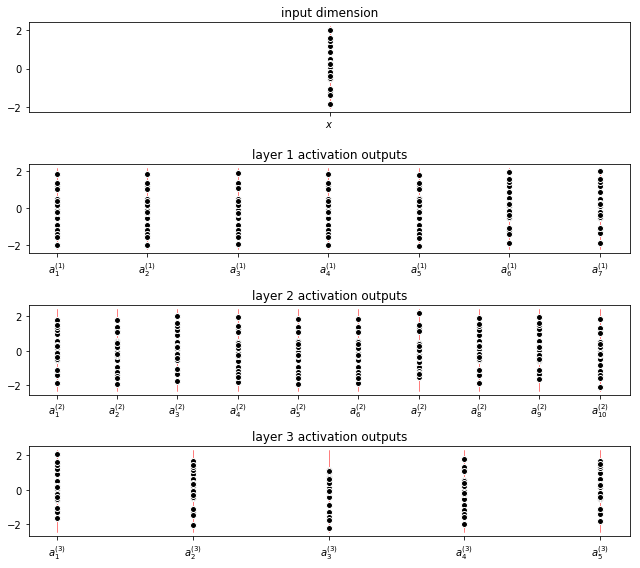

In [30]:
# plot the normalized input and activation output distributions for our network
plotter_demo.activation_distributions(x,w_init,kind = 'normalized')

These look far better in general than the unnormalized case, and so we can expect that gradient descent will have a much easier time optimizing the normalized network.

#### <span style="color:#a50e3e;">Example 7. </span>  Comparing unnormalized and normalized deep network activation output distributions for regression

In this example we compare the speed at which gradient descent can tune a 4 layer architecture, and the same architecture with its input and each activation output normalized, to fit our noisy sinusoidal dataset.  The network uses the `tanh` activation, has 10 units in each layer, and is defined / initialized in the next cell using the ``initialize_network_weights`` detailed in the previous example as well as the notes on multilayer perceptrons / feedforward networks.

In [31]:
# load data
csvname = 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:,:-1]
y = data[:,-1:]

In [32]:
# A 3 layer network architecture
N = np.shape(x)[1]
M = np.shape(y)[1]
U_1 = 10                # number of units in layer 1
U_2 = 10               # number of units in layer 2
U_3 = 10                # number of units in layer 3

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,M]

# generate initial weights for our network
w_init = initialize_network_weights(layer_sizes,scale = 0.1)

First we tune the raw network.  Below we have our standard ``predict`` and ``least_squares`` functions. 

In [33]:
# our predict function 
def predict(x,w):     
    # feature trasnsformations
    f = compute_features(x,w[0])
    
    # compute linear model
    vals = np.dot(f,w[1])
    return vals

# least squares
least_squares = lambda w: np.sum((predict(x,w) - y)**2)

In the next cell we run gradient descent to fit our (unnormalized) network model using 2000 steps of (unnormalized) gradient descent with a steplength parameter $\alpha$ of the form $10^{-\gamma}$ where $\gamma$ is the smallest positive integer that produces convergence with our random initial point.

In [34]:
# parameters of gradient descent
alpha = 10**(-3); max_its = 2000; beta = 0; 

# run gradient descent, create cost history (for cost function plot comparison) associated with output weight history
weight_history_1 = gradient_descent(least_squares,w_init,alpha,max_its,beta,version = 'unnormalized')
cost_history_1 = [least_squares(v) for v in weight_history_1]

Next, we perform the same experiment using the normalized form of the exact network.  Here the input, as well as each activation output, has been normalized according to its respective distribution.  Note here the normalized network is computed by the function ``compute_features_normalized``, which was defined in the previous example.  Note: here we input the normalized data into our prediction function.  To distinguish our ``least_squares`` function that takes in this normalized predictor, we call it ``least_squares_normalized``.

In [35]:
# compute the mean and standard deviation of our input, then normalize the input
x_means = np.mean(x,axis = 0)
x_stds = np.std(x,axis = 0)

# normalize the input data
x_normed = normalize(x,x_means,x_stds)

In [36]:
# our predict function 
def predict_normalized(x,w):     
    # feature trasnsformations
    f = compute_features_normalized(x,w[0])
    
    # compute linear model
    vals = np.dot(f,w[1])
    return vals

# least squares
least_squares_normalized = lambda w: np.sum((predict_normalized(x_normed,w) - y)**2)

Now we perform the same run of gradient descent as done previously, using the same initialization.

In [37]:
# parameters of gradient descent
alpha = 10**(-3); max_its =2000; beta = 0; 

# run gradient descent, create cost history (for cost function plot comparison) associated with output weight history
weight_history_2 = gradient_descent(least_squares_normalized,w_init,alpha,max_its,beta,version = 'unnormalized')
cost_history_2 = [least_squares_normalized(v) for v in weight_history_2]

With both runs complete we can now examine their cost histories to visualize just how much faster the gradient descent works on the normalized architecture.  The difference in convergence behavior is enormous.

/Users/ikhlas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


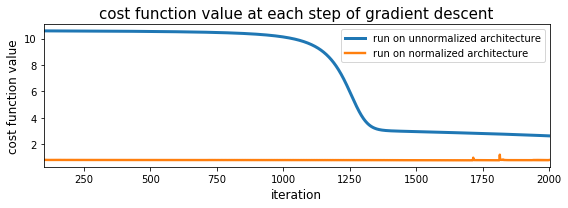

In [38]:
# plot the cost function history for our current run of gradient descent
histories = [cost_history_1, cost_history_2]
labels = ['run on unnormalized architecture','run on normalized architecture']
plotter_demo.compare_regression_histories(histories,start=100,labels=labels)

Now we want to plot the fit provided by both runs.  But remember, as we saw in when discussing the normalization of fixed features, we need to be careful when doing this with our normalized architecture.  This is because the normalized version of the network *is normalized with respect to the training data* - in this case our noisy sinusoidal dataset.  Thus in order to properly evaluate test points - like a fine range of input values we can use to illustrate the fit of the normalized architecture - these test points must be normalized with respect to the same network statistics (i.e., the same input and activation output distribution normalizations) used to evaluate the training data.  

> In order to properly evaluate test points with our normalized architecture they must be normalized with respect to the same network statistics (i.e., the same input and activation output distribution normalizations) used for the training data.

So - practically speaking - to evaluate test points for a given set of weights (like the final weights learned by gradient descent) we must first pass our training data and this set of weights back through the network and collect all of the input / activation output means and standard deviations used in the normalization process.   Then when we evaluate the new test points normalization is performed with *these training statistics*.  

The function ``compute_features_normalized_testing`` function below performs both of these tasks.  Passing the training data and a set of weights through it we can collect the training statistics in the container called ``stats``.  Then we can use the same function to evaluate new test points by passing the test data, the same set of weights, and these statistics to the function.

In [39]:
def compute_features_normalized_testing(x, inner_weights,stats):
    '''
    An adjusted normalized architecture compute function that collects network statistics as the training data
    passes through each layer, and applies them to properly normalize test data.
    '''
    # are you using this to compute stats on training data (stats empty) or to normalize testing data (stats not empty)
    switch =  'testing'
    if np.size(stats) == 0:
        switch = 'training'
        
    # if no stats given collect directly from input
    x_means = 0
    y_means = 0
    if switch == 'training':
        x_means = np.mean(x,axis = 0)
        x_stds = np.std(x,axis = 0)
        stats.append([x_means,x_stds])
    elif switch == 'testing':
        x_means = stats[0][0]
        x_stds = stats[0][1]

    # normalize input
    x_normed = normalize(x,x_means,x_stds)
    
    # pad data with ones to deal with bias
    o = np.ones((np.shape(x_normed)[0],1))
    a_padded = np.concatenate((o,x_normed),axis = 1)
        
    # loop through weights and update each layer of the network
    c = 1
    for W in inner_weights:
        # output of layer activation
        a = activation(np.dot(a_padded,W))
                
        ### normalize output of activation
        a_means = 0
        a_stds = 0
        if switch == 'training':
            # compute the mean and standard deviation of the activation output distributions
            a_means = np.mean(a,axis = 0)
            a_stds = np.std(a,axis = 0)
            stats.append([a_means,a_stds])
        elif switch == 'testing':
            a_means = stats[c][0]
            a_stds = stats[c][1]
            
        # normalize the activation outputs
        a_normed = normalize(a,a_means,a_stds)
            
        # pad with ones for bias
        o = np.ones((np.shape(a_normed)[0],1))
        a_padded = np.concatenate((o,a_normed),axis = 1)
        c+=1
    
    return a_padded,stats

In the next cell we use the function above to compute the training statistics with respect to the best weights of the gradient descent run on our normalized architecture.

In [40]:
# get best weights from first run
best_ind = np.argmin(cost_history_1)
w1 = weight_history_1[best_ind]

# collect training normalization statistics for the final set of weights learned by gradient descent
best_ind = np.argmin(cost_history_2)
w2 = weight_history_2[best_ind]
a_padded,training_stats = compute_features_normalized_testing(x,w2[0],[])

Now to use our ``compute_features_normalized_testing`` function on new test data we create a testing prediction function that calls it, which we call ``predict_testing``.

In [41]:
# our predict function 
def predict_testing(x,w):     
    # feature trasnsformations
    f,stats = compute_features_normalized_testing(x,w[0],training_stats)
    
    # compute linear model
    vals = np.dot(f,w[1])
    return vals

Finally with this adjustment made to evaluate test points with our normalized architecture we can evaluate and compare both the original and normalized architectures - using their final weights learned from their respective gradient descent runs - to compare them on new test points.  Below we evaluate both architectures over a fine range of testing input to illustrate the final fit of each architecture.

As we saw earlier - gradient descent could minimize the normalized architecture substantially more than the original.  This fact is reflected in the quality of the nonlinear fit each model provides for the data - with the normalized version being significantly better.

/Users/ikhlas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


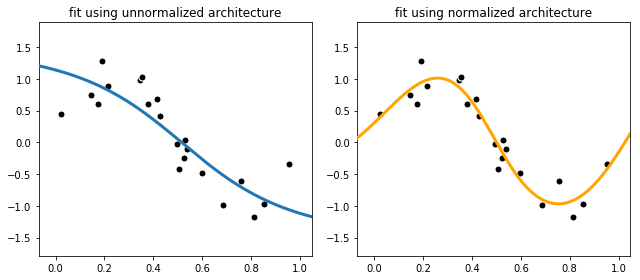

In [42]:
# compare final fits using unnormalized and normalized predictors
plotter_demo.compare_regression_fits(x,y,predict,predict_testing,w1,w2,title1 = 'fit using unnormalized architecture',title2 = 'fit using normalized architecture')

With such a higly parameterized architecture one might suspect that we should be able overfit significantly to this dataset.  This will certainly occur if we continue to run (unnormalized) gradient descent to minimize e.g., the normalized least squares cost.  However using other first order tricks one can further speed up gradient descent - like e.g., the normalized gradient descent step or momentum - and overfit rather quickly here.

#### <span style="color:#a50e3e;">Example 8. </span>  Comparing unnormalized and normalized deep network activation output distributions for classification

In this example we compare the speed at which gradient descent converges when using a standard and normalized architecture to perform nonlinear classification, using the dataset shown below.

/Users/ikhlas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


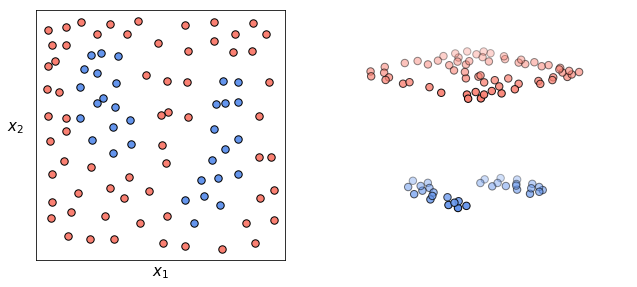

In [43]:
# load data
csvname = '2_eggs.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:,:-1]
y = data[:,-1:]

# plot everything
plotter_demo = plotter.Visualizer()
plotter_demo.plot_classification_data(x,y)

Here we will use a 3 layer network, with 10 units in each layer.  This network is defined and initialized in the cell below.

In [44]:
# A 3 layer network architecture
N = np.shape(x)[1]
M = np.shape(y)[1]
U_1 = 10                # number of units in layer 1
U_2 = 10                # number of units in layer 2
U_3 = 10                # number of units in layer 3

# the list defines our network architecture
layer_sizes = [N, U_1,U_2,U_3,M]

# generate initial weights for our network
w_init = initialize_network_weights(layer_sizes,scale = 0.8)

Below we define our ``softmax`` cost function, as well as the counting cost (to count the number of misclassifications at each step of gradient descent) called ``count``.

In [45]:
# softmax cost function
softmax = lambda w: np.sum(np.log(1 + np.exp(-y*predict(x,w))))
count = lambda w: 0.25*np.sum((np.sign(predict(x,w)) - y)**2)

Now we run (unnormalized) gradient descent for 200 iterations to tune our original architecture.  Here we use our standard steplength value $\alpha$ of the form $10^{-\gamma}$ for the smallest positive integer $\gamma$ that provides convergence.

In [46]:
# parameters of gradient descent
alpha = 10**(-3); max_its = 200; beta = 0; version = 'unnormalized'
cost = softmax

# run gradient descent, create cost history (for cost function plot comparison) associated with output weight history
weight_history_1 = gradient_descent(cost,w_init,alpha,max_its,beta,version = version)
count_history_1 = [count(v) for v in weight_history_1]
cost_history_1 = [softmax(v) for v in weight_history_1]

Next we do the same for our unnormalized version of the network.  In the next cell we normalize the input data, and define softmax and counting cost functions ``softmax_normalized`` and ``count_normalized`` that take in this normalized data.

In [47]:
# compute the mean and standard deviation of our input, then normalize the input
x_means = np.mean(x,axis = 0)
x_stds = np.std(x,axis = 0)

# normalize the input data
x_normed = normalize(x,x_means,x_stds)

# softmax cost function
softmax_normalized = lambda w: np.sum(np.log(1 + np.exp(-y*predict_normalized(x_normed,w))))
count_normalized = lambda w: 0.25*np.sum((np.sign(predict_normalized(x_normed,w)) - y)**2)

Now we make the analagous run of gradient descent to tune the parameters of our normalized architecture.

In [48]:
# parameters of gradient descent
alpha = 10**(-3); max_its = 200; beta = 0; version = 'unnormalized'
cost = softmax_normalized

# run gradient descent, create cost history (for cost function plot comparison) associated with output weight history
weight_history_2 = gradient_descent(cost,w_init,alpha,max_its,beta,version = version)
count_history_2 = [count_normalized(v) for v in weight_history_2]
cost_history_2 = [softmax_normalized(v) for v in weight_history_2]

With both gradient descent runs complete we can compare the cost function value and number of misclassifications at each step of the runs.  This is plotted below.  As with the previous regression example, the difference in terms of convergence is enormous, with gradient descent converging much more rapidly with the normalized architecture.

/Users/ikhlas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


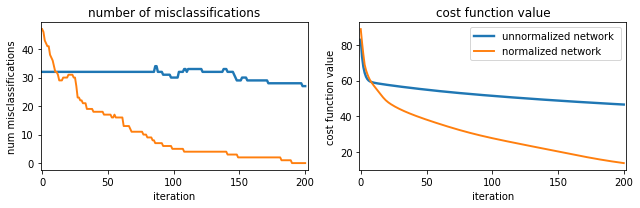

In [49]:
# plot cost function history
start = 0   # at which iteration to begin plotting the cost function history
count_histories = [count_history_1,count_history_2]
cost_histories = [cost_history_1,cost_history_2]

labels = ['unnormalized network ','normalized network']
plotter_demo.compare_classification_histories(count_histories,cost_histories,start,labels = labels)

Since the unnormalized fit is clearly quite poor after only 200 iterations of gradient descent, we just examine the fit of the tuned normalized architecture.  As discussed in the previous example, in order to visualize this fit we must extract the normalization statistics from our network when passing the training data (and desired set of weights) through it.  We do this in the next cell, employing the same functionality for doing so introduced in the previous example.

In [50]:
# extract normalization statistics from the network over our training data
best_ind = np.argmin(cost_history_2)
w2 = weight_history_2[best_ind]
a_padded,training_stats = compute_features_normalized_testing(x,w2[0],[])

To evaluate new test points using this set of training statistics we define a ``predict_testing`` function below.

In [51]:
# our predict function 
def predict_testing(x,w):     
    # feature trasnsformations
    f,stats = compute_features_normalized_testing(x,w[0],training_stats)
    
    # compute linear model
    vals = np.dot(f,w[1])
    return vals

With our statistics computed and testing predictor constructed we can now properly evaluate test points with our normalized architecture.  In particular we can evaluate a fine set of test points over the input range of our dataset to produce a visualization of the normalized architecture's nonlinear fit - which we do below.  In the left panel the fit is shown 'from above', while in the right panel the same fit is shown from the regression point of view 'from the side'.  The fit is a good one, producing zero misclassifications.

/Users/ikhlas/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


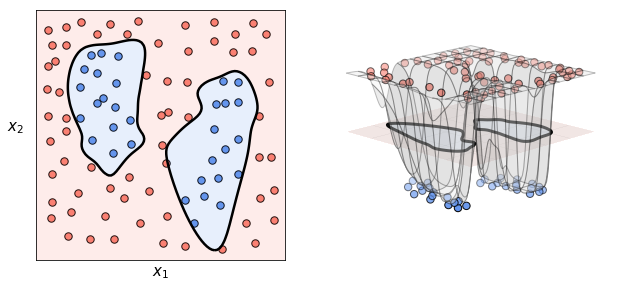

In [52]:
# plot the dataset along with classification boundary (in the left panel) and corresponding surface fit (in the right panel)
plotter_demo.plot_classification_data(x,y,predict = predict_testing,weights = weight_history_2[-1])